In [1]:
import ipywidgets
import umap.umap_ as umap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, adjusted_rand_score
import seaborn as sns
import os
from ipywidgets import interact
from matplotlib.widgets import Slider
from umap import UMAP

# Part 1: Supervised Learning
## 1a. Data Loading and Cleaning

In [8]:
# load from subfolder relative to current directory and drop missing

trainX = pd.read_csv('train.csv')
testX = pd.read_csv('test.csv')
trainY = pd.read_csv('train_short_labels.csv')
testY = pd.read_csv('test_short_labels.csv')
blindX = pd.read_csv('blind_test.csv')

# versions of the dataframes without missing values. In other situations we want to keep the existence of the rows in order to do the 
# movmean properly, or else delete the whole chunk (unnecessary)
trainX_nn = trainX.dropna()
testX_nn = testX.dropna()
trainY_nn = trainY.dropna()
testY_nn = testY.dropna()
blindX_nn = blindX.dropna()
    
# get regular matrix copies because i'm a neanderthal 
trainX_m = trainX_nn.to_numpy()
testX_m = testX_nn.to_numpy()
trainY_m = trainY_nn.to_numpy()
testY_m = testY_nn.to_numpy()
blindX_m = blindX_nn.to_numpy()

# 150 row chunks

In [9]:
import scipy.spatial
from scipy.spatial import ConvexHull

def getAreas(matrix):
    area = np.zeros((len(matrix), 2))

    for i in range(0,len(matrix)):
        temp = np.hsplit(matrix[i,1:27], 2)
        temp = np.transpose(temp)
        area[i, 0] = ConvexHull(temp).area

        temp = np.hsplit(matrix[i,27:53], 2)
        temp = np.transpose(temp)
        area[i, 1] = ConvexHull(temp).area

    return area

trainX_area = getAreas(trainX_m)
testX_area = getAreas(testX_m)
blindX_area = getAreas(blindX_m)

Text(0.5, 0, 'Area')

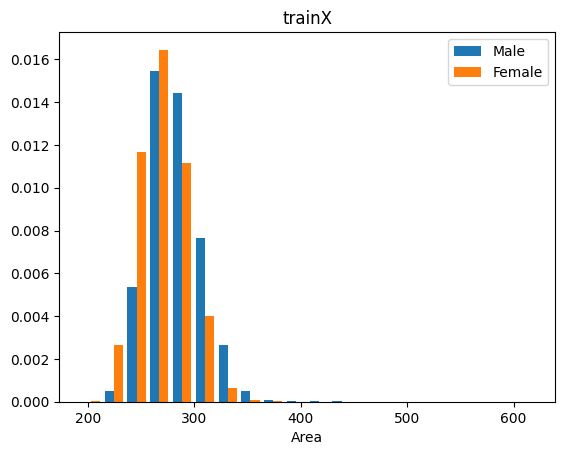

In [16]:
import matplotlib.pyplot as plt

plt.hist(trainX_area, 20, label=["Male", "Female"], density=True)
plt.legend()
plt.title("trainX")
plt.xlabel("Area")


In [4]:
import scipy.stats

#scipy.stats.wilcoxon(area)
scipy.stats.spearmanr(area[:, 1], trainX_m[:,37])

SignificanceResult(statistic=0.017938112322406587, pvalue=1.5156234019465962e-18)